# COMP 47460 Assignment 2

Student Number - 19200851

Student Name   - Shruti Sivanandam Palamadai

In [3]:
#importing required libraries
import requests
from bs4 import BeautifulSoup, SoupStrainer
import pandas as pd
import nltk
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
import string
import numpy.random as npr
import requests
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

I have chosen Hotels, Gym & Hair and Salons as the three categories. The following code fetches the urls for the set of reviews for each category

In [4]:
def get_urls(sub_url):
    # Response object to get the webpage.
    url = 'http://mlg.ucd.ie/modules/yalp/'
    urls=[]
    response = requests.get(sub_url)
    # Data contains the source code of the webpage.
    data = response.text
    # Parsing the source code
    soup = BeautifulSoup(data, 'html.parser')
    # Extract the URLs for all the hotels
    urls =[url+ link.get("href") for link in soup.find_all("a",href=True)]
    return urls

# Fetching hotel links.
hotel_list = 'http://mlg.ucd.ie/modules/yalp/hotels_list.html'
hotel_urls = get_urls(hotel_list)

# Fetching gym links.
gym_list = 'http://mlg.ucd.ie/modules/yalp/gym_list.html'
gym_urls = get_urls(gym_list)

# Fetching hair and salon links.
hair_salon_list = 'http://mlg.ucd.ie/modules/yalp/hair_salons_list.html'
hair_salon_urls =  get_urls(hair_salon_list)

In the following code the review text is extracted for each review and is labelled as positive or negative depending on ratiing being above or below 3. The data is finally stored as a dataframe with two colums - Review and Label.

In [5]:
def extract_and_label_reviews(url_list): 
    reviews = [] # List of reviews  
    ratings= []  # List of the ratings of each review 
    for urls in url_list:
        if 'index' in urls:
            pass
        # retrieve the data from the specified base url. 
        base_data = requests.get(urls)
        # scrape the contents of the web page
        scraper = BeautifulSoup(base_data.content,'html.parser')
        # extract a particular class inside a tag
        reviews_text = scraper.find_all('p',{"class":"review-text"})
        for review in reviews_text:
            reviews.append(review.text)
        
        # Ratings exists in alt tag of the img tags.
        rating_value = scraper.find_all('img',alt=True)    
        for rating in rating_value:
            # if rating is less than 3: The review is labelled as Negative.
            if int(rating.get('alt')[0])<=3:
                ratings.append('negative')       
            # if rating is greater than 3: The review is labelled as Positive.
            else:
                ratings.append('positive')

        # Dictionary of Reviews and Ratings
        dict_reviews = {'Review': reviews,'Label':ratings}
        
    return dict_reviews

# Storing the reviews and their ratings in a df.
dict_hotel_reviews = extract_and_label_reviews(hotel_urls)
hotel_df = pd.DataFrame(dict_hotel_reviews)

dict_gym_reviews = extract_and_label_reviews(gym_urls)
gym_df = pd.DataFrame(dict_gym_reviews)

dict_hair_salon_reviews = extract_and_label_reviews(hair_salon_urls)
hair_salon_df = pd.DataFrame(dict_hair_salon_reviews)

Now the Review text will need to be preprocessed before converting to an appropriate numeric representation. The standard text pre-processing methods are used here such as 

Whitespace removal

Stop words removal

Converting to lowercase

lemmatizing the words

Removing words that contain numbers.

All the above has been done so that the final numerical representation will be more accurate to model our data on.

In [6]:
#clean up and lemmatize the words in review text
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
lemmatizer = nltk.stem.WordNetLemmatizer()
# Function to clean the text.
def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = nltk.corpus.stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    pos_tags = nltk.pos_tag(text)
    text = [lemmatizer.lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# Invoke the clean_text function for Review of each dataframe.
hotel_df['Review'] = hotel_df.Review.apply(clean_text)
gym_df['Review'] = gym_df.Review.apply(clean_text)
hair_salon_df['Review'] = hair_salon_df.Review.apply(clean_text)
print(hotel_df.head(5)) # to demonstrate cleaned text

                                              Review     Label
0  melissa take tour asia space hour definitely k...  positive
1  group seven visit montreal week look tour woul...  positive
2  melissa gem fiancé find tour viator check trip...  positive
3  perfect day montreal melissa outfit bike deftl...  positive
4  really great food truck tour melissa montreal ...  positive


Now the data needs to be converted to an appropriate numerical representation in order to run a text classification algorithm on it. In this case tf-idf is an extrmely useful measure that helps in measuring the importance of a certain word in a corpus.tf–idf or TFIDF, short for term frequency-inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.The tf–idf value increases proportionally to the number of times a word appears in the document and is offset by the number of documents in the corpus that contain the word, which helps to adjust for the fact that some words appear more frequently in general. While this will be helpful for the classification algorithm we will be running shortly, it can also help in the future in sentiment analysis of the reviews and analyzing which key words occur more often in negative vs positive reviews

In [7]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9,min_df=0.01,use_idf=True)

tfidf_matrix = tfidf_vectorizer.fit_transform(hotel_df['Review'])
terms = tfidf_vectorizer.get_feature_names() # this will extract all keywords from our cleaned text of the review

# Dataframe with column names as the features from the vectorised object.
hotel_review_df = pd.DataFrame(tfidf_matrix.todense(), columns = terms)
hotel_review_df['Label'] = hotel_df['Label']
print(hotel_review_df.head(3)) # to show how the df looks

tfidf_matrix = tfidf_vectorizer.fit_transform(gym_df['Review'])
terms = tfidf_vectorizer.get_feature_names()
gym_review_df= pd.DataFrame(tfidf_matrix.todense(), columns = terms)
gym_review_df['Label'] = gym_df['Label']


tfidf_matrix = tfidf_vectorizer.fit_transform(hair_salon_df['Review'])
terms = tfidf_vectorizer.get_feature_names()
hair_salon_review_df = pd.DataFrame(tfidf_matrix.todense(), columns = terms)
hair_salon_review_df['Label'] = hair_salon_df['Label']

   aaa  able  absolutely   ac  access  accommodate  across  activity  \
0  0.0   0.0         0.0  0.0     0.0          0.0     0.0       0.0   
1  0.0   0.0         0.0  0.0     0.0          0.0     0.0       0.0   
2  0.0   0.0         0.0  0.0     0.0          0.0     0.0       0.0   

   actually  add  ...  wow  write  wrong  year  yelp  yes  yet  young  zero  \
0       0.0  0.0  ...  0.0    0.0    0.0   0.0   0.0  0.0  0.0    0.0   0.0   
1       0.0  0.0  ...  0.0    0.0    0.0   0.0   0.0  0.0  0.0    0.0   0.0   
2       0.0  0.0  ...  0.0    0.0    0.0   0.0   0.0  0.0  0.0    0.0   0.0   

      Label  
0  positive  
1  positive  
2  positive  

[3 rows x 974 columns]


The following code models the data using logistic regression. The data has ben split to be 70% for training and 30% for test.
The accuracy score gives us an idea has to how well the model is able to classify the data. Confusion Matrix represents the number of classes correctly and incorrectly classified. 


Training and Testing Hotel Reviews
Review Accuracy = 0.90
              precision    recall  f1-score   support

    positive       0.98      0.77      0.86       257
    negative       0.85      0.99      0.91       343

    accuracy                           0.90       600
   macro avg       0.91      0.88      0.89       600
weighted avg       0.91      0.90      0.89       600



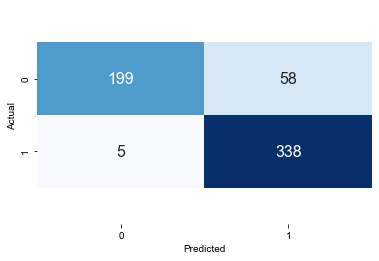


Training and Testing Gym Reviews
Review Accuracy = 0.90
              precision    recall  f1-score   support

    positive       0.89      0.78      0.83       197
    negative       0.90      0.95      0.93       403

    accuracy                           0.90       600
   macro avg       0.89      0.87      0.88       600
weighted avg       0.90      0.90      0.89       600



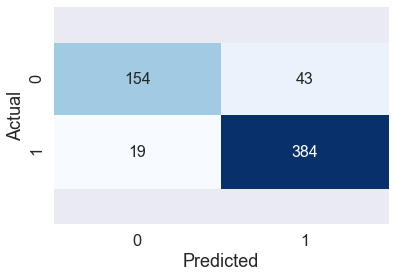


Training and Testing Hair Salon Reviews
Review Accuracy = 0.91
              precision    recall  f1-score   support

    positive       0.94      0.61      0.74       122
    negative       0.91      0.99      0.95       478

    accuracy                           0.91       600
   macro avg       0.92      0.80      0.85       600
weighted avg       0.92      0.91      0.91       600



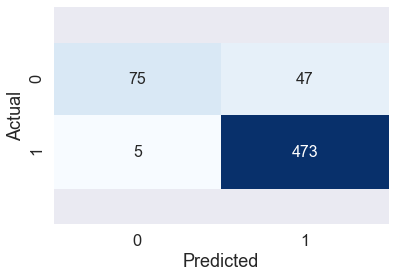

In [8]:
def lr_model(df):
    npr.seed(123)
    X_Train,X_Test,Y_Train,Y_Test = train_test_split(df.iloc[:,:-1], df.iloc[:,-1], test_size = 0.3)
    lr = LogisticRegression()
    lr.fit(X_Train, Y_Train)
    lr_y_pred = lr.predict(X_Test)
    print("Review Accuracy = %.2f" % accuracy_score(Y_Test, lr_y_pred) )
    cm = confusion_matrix(Y_Test, lr_y_pred)
    print(classification_report(Y_Test, lr_y_pred, target_names=["positive","negative"]))
    fig, ax = plt.subplots(figsize=(6,4))
    sn.heatmap(cm, annot=True, cbar = False, fmt = 'd', annot_kws= {'size':16}, cmap= 'Blues')
    sn.set(font_scale= 1.5)
    # Align the text in middle.
    bottom,top = ax.get_ylim()
    ax.set_ylim(bottom +0.5, top - 0.5)

    # Assign labels to X and Y axis.
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()
    
print("\nTraining and Testing Hotel Reviews")
lr_model(hotel_review_df)#974 cols

print("\nTraining and Testing Gym Reviews")
lr_model(gym_review_df)#925 cols

print("\nTraining and Testing Hair Salon Reviews")
lr_model(hair_salon_review_df)#716 cols

As seen above above, the results with logistic regression are quite good. Logistic Regression works well when we have to model a binary dependent variable. In this case the label- positive/negative is the binary dependent variable. The accuracy for all the categories is >=0.90. We can see that for the hair salon reviews, the classes are highly imbalanced. In such a case, it is good practice to look at the f1 score more than the accuracy as it measures the harmonic mean of precision and recall. We can see that the f1 score is decent for the positive classes and very good for the negative classes. 

Now we will model the data on one category and test it on the other two categories to see how that affects the performance of the model.

In [9]:
def model_test_on_category(df_A,df_B,df_C):
    npr.seed(123)
    #training model on category A and testing on Category B and Category C
    X_Train,X_Test,Y_Train,Y_Test = train_test_split(df_A.iloc[:,:715], df_A.iloc[:,-1], test_size = 0.3)
    #using 715 columns as smallest dataframe has 716 columns total inclusing label
    #and including any more will lead to out of index error while testing
    
    # Logistic Regression Classifier.
    categoryA_reg = LogisticRegression()
    
    # Fitting the model
    categoryA_reg.fit(X_Train, Y_Train)
    
    # Taking the same number of features in across three datasets to be able to evaluate the two categories against the classification model of one category.
    X_categoryB_Test = df_B.iloc[:,:715]
    Y_categoryB_Test = df_B.iloc[:,-1]
    
    X_categoryC_Test = df_C.iloc[:,:715]
    Y_categoryC_Test = df_C.iloc[:,-1]
    
    # Evaluate gym and hair salon on the model built on hotel
    
    Y_categoryB_pred = categoryA_reg.predict(X_categoryB_Test)
    print("Category B Review Accuracy = %.2f" % accuracy_score(Y_categoryB_Test, Y_categoryB_pred) )
    
    
    Y_categoryC_pred = categoryA_reg.predict(X_categoryC_Test)
    print("Category C Review Accuracy = %.2f" % accuracy_score(Y_categoryC_Test, Y_categoryC_pred) )

print("\nModelling on Category A - Hotel and testing on Category B - Gym & Category C - Hair Salon")
model_test_on_category(hotel_review_df,gym_review_df,hair_salon_review_df)

print("\nModelling on Category A - Gym and testing on Category B - Hotel & Category C - Hair Salon")
model_test_on_category(gym_review_df,hotel_review_df,hair_salon_review_df)

print("\nModelling on Category A - Hair Salon and testing on Category B - Hotel & Category C - Gym")
model_test_on_category(hair_salon_review_df,hotel_review_df,gym_review_df)


Modelling on Category A - Hotel and testing on Category B - Gym & Category C - Hair Salon
Category B Review Accuracy = 0.55
Category C Review Accuracy = 0.47

Modelling on Category A - Gym and testing on Category B - Hotel & Category C - Hair Salon
Category B Review Accuracy = 0.52
Category C Review Accuracy = 0.70

Modelling on Category A - Hair Salon and testing on Category B - Hotel & Category C - Gym
Category B Review Accuracy = 0.58
Category C Review Accuracy = 0.65


Now since the hair salon has the smallest amount of independent variables to model on, i.e in this case the number of distinct terms/keywords in the review - 715 this would obviously impact testing in all three cases as for the other two categories we will only be able to consider 715 terms too inspite there being more. This is why when we trained model on hotel and gym reviews it lead to a relatively lower accuracy than when modelled using hair salon category. But overall we can see that logistic regression is a good fit for the data we have and we could also further use it for sentiment analysis.